# Conformal Object Detection: first steps

This tutorial should get you started doing **Conformal Object Detection (COD)** with the [`cods`](https://github.com/leoandeol/cods) library.

For more information on the methods implemented in CODS, see the papers: 
- [Andéol et al. 2023: Confident Object Detection via Conformal Prediction and Conformal Risk Control](https://proceedings.mlr.press/v204/andeol23a.html)
- [Angelopoulos et al. 2022: Conformal Risk Control](https://arxiv.org/abs/2208.02814)
- [Li et al. 2022: Towards PAC Multi-Object Detection and Tracking](https://arxiv.org/abs/2204.07482)
- [Bates et al. 2021: Risk Controlling Prediction Sets](https://dl.acm.org/doi/abs/10.1145/3478535)


### Get started
1. Download the MS-COCO dataset: 
    - https://cocodataset.org/
2. Download DETR: automatically via Pytorch hub: https://pytorch.org/hub/
    - source: https://github.com/facebookresearch/detr

### Contents
What we will be doing:
1. Setup inference [⤵](#Setup-inferences)
    - load predictor (DETR) pretrained on COCO
    - Split the validation into: calibration & validation dataset
2. Run inferences on these datasets [⤵](#Setup-inferences)
    - Save predictions to disk: faster than re-predict for every test
3. Test Conformal Prediction !

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from cods.od.data import MSCOCODataset
from cods.od.models import YOLOModel, DETRModel
import logging
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = (
    "1"  # chose the GPU. If only one, then "0"
)

logging.getLogger().setLevel(logging.INFO)

## 2. Setup inferences [🔝](#conformal-object-detection-first-steps)

In [3]:
# set [COCO_PATH] to the directory to your local copy of the COCO dataset
COCO_PATH = "/datasets/shared_datasets/coco/"

data = MSCOCODataset(root=COCO_PATH, split="val")

In [4]:
calibration_ratio = (
    0.5  # set 0.5 to use 50% for calibration and 50% for testing
)

use_smaller_subset = False  # TODO: Temp

if use_smaller_subset:
    data_cal, data_val = data.split_dataset(
        calibration_ratio, shuffle=False, n_calib_test=800
    )
else:
    data_cal, data_val = data.split_dataset(calibration_ratio, shuffle=False)

# model and weights are downloaded from https://github.com/facebookresearch/detr
model = DETRModel(model_name="detr_resnet50", pretrained=True, device="cpu")
# model = YOLOModel(model_name="yolov8x.pt", pretrained=True)


print(f"{len(data) = }")
print(f"{len(data_cal) = }")
print(f"{len(data_val) = }")

Using cache found in /home/leo.andeol/.cache/torch/hub/facebookresearch_detr_main
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/leo.andeol/envs/cods_13/cods/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


len(data) = 5000
len(data_cal) = 2500
len(data_val) = 2500


Run inferences:
- the first time, run inferences and save them disk
- if predictions are saved on disk, load them

In [5]:
preds_cal = model.build_predictions(
    data_cal,
    dataset_name="mscoco",
    split_name="cal",
    batch_size=12,
    collate_fn=data._collate_fn,  # TODO: make this a default for COCO
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)
preds_val = model.build_predictions(
    data_val,
    dataset_name="mscoco",
    split_name="test",
    batch_size=12,
    collate_fn=data._collate_fn,
    shuffle=False,
    force_recompute=False,
    deletion_method="nms",
)

Predictions already exist, loading them...
Predictions already exist, loading them...


# New Tests

In [8]:
from cods.od.cp import ODConformalizer

conf = ODConformalizer(
    backend="auto",
    guarantee_level="image",
    matching_function="mix",
    multiple_testing_correction=None,
    confidence_method="box_count_twosided_recall",  # "nb_boxes",
    localization_method="pixelwise",
    localization_prediction_set="additive",
    classification_method="binary",
    classification_prediction_set="lac",
)

[2025-05-07 02:20:31:WARNING:cp.py:cp:1499 - __init__ ] No multiple_testing_correction provided, assuming no correction is needed. The explicit list of alphas is expected for calibration.
[2025-05-07 02:20:31:INFO:cp.py:cp:197 - __init__ ] Defaulting to CRC backend
[2025-05-07 02:20:31:INFO:cp.py:cp:1037 - __init__ ] Defaulting to CRC backend


In [11]:
# TODO(leo): we can replace this by anything, doesn't even need a guarantee (confidence)
parameters = conf.calibrate(
    preds_cal,
    alpha_confidence=0.02,
    alpha_localization=0.05,
    alpha_classification=0.05,
)


[2025-05-07 02:21:40:INFO:cp.py:cp:1739 - calibrate ] Calibrating Confidence Conformalizer
[2025-05-07 02:21:40:INFO:cp.py:cp:823 - calibrate ] Replacing previously computed λ
100%|██████████| 2500/2500 [00:01<00:00, 1257.07it/s]


First risk: 0.0043982407078146935


λ=0.9999938011169434. Corrected Risk = 0.0092:   1%|          | 852/100496 [00:02<04:06, 404.08it/s]

λ=0.9999750256538391. Corrected Risk = 0.0204:   2%|▏         | 2445/100496 [00:06<03:50, 425.70it/s][2025-05-07 02:21:49:INFO:optim.py:optim:421 - optimize ] Solution Found: 0.9999750256538391 with risk 0.02039184235036373


--------------------------------------------------
Lambdas
	previous_lbd = 0.9999750256538391
	Last Lambda = 0.9999750256538391
	Other previous lbd = 0.9999750256538391
	Other current lbd = 0.9999750256538391
All risks raw (precomputed):
	Confidence Risk: 0.019992003217339516
	Localization Risk: 0.0003998400643467903
	Classification Risk: 0.0003998400643467903
	Max Risk: 0.019992003217339516
All risks monotonized (precomputed):
	Confidence Risk: 0.019992003217339516
	Localization Risk: 0.0003998400643467903
	Classification Risk: 0.0003998400643467903
	Max Risk: 0.019992003217339516
Confidence risk (recomputed):


λ=0.9999750256538391. Corrected Risk = 0.0204:   2%|▏         | 2462/100496 [00:06<04:23, 372.23it/s]

	Confidence Risk: 0.02280000038444996
Comparison of the two :
	 (isclose) 0.9972000122070312
	 (eq) 0.9972000122070312
	Image 326 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 326 confidence: tensor([9.9688e-01, 6.4486e-05, 3.4364e-05, 2.8835e-05, 2.1178e-05, 1.6436e-05, 5.4206e-06, 2.2345e-06])
	Image 326 number of ground truths: 1
	Image 326 number of predictions: 4
	Image 542 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 542 confidence: tensor([9.9926e-01, 6.9327e-04, 1.1316e-04, 4.8616e-05, 8.1143e-06, 5.9935e-06, 1.7072e-06, 8.6106e-07])
	Image 542 number of ground truths: 1
	Image 542 number of predictions: 4
	Image 881 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 881 confidence: tensor([9.9830e-01, 1.5593e-04, 1.4033e-04, 3.6695e-05, 2.4465e-05, 1.7059e-05, 1.2246e-05, 3.6974e-06, 7.1466e-07])
	Image 881 number of ground truths: 1
	Image 881 number of predictions: 4
	Image 1063 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 1063 confidence


100%|██████████| 2500/2500 [00:01<00:00, 1271.38it/s]


First risk: 0.003998400643467903


λ=0.9999732971191406. Corrected Risk = 0.0204:   3%|▎         | 2548/100496 [00:06<04:08, 393.56it/s][2025-05-07 02:21:59:INFO:optim.py:optim:421 - optimize ] Solution Found: 0.9999732971191406 with risk 0.02039184235036373


--------------------------------------------------
Lambdas
	previous_lbd = 0.9999732971191406
	Last Lambda = 0.9999732971191406
	Other previous lbd = 0.9999732971191406
	Other current lbd = 0.9999732971191406
All risks raw (precomputed):
	Confidence Risk: 0.019992003217339516
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019992003217339516
All risks monotonized (precomputed):
	Confidence Risk: 0.019992003217339516
	Localization Risk: 0.0
	Classification Risk: 0.0
	Max Risk: 0.019992003217339516
Confidence risk (recomputed):


λ=0.9999732971191406. Corrected Risk = 0.0204:   3%|▎         | 2560/100496 [00:06<04:20, 375.75it/s]
[2025-05-07 02:21:59:INFO:cp.py:cp:1749 - calibrate ] Setting Confidence Threshold of Predictions
[2025-05-07 02:21:59:INFO:cp.py:cp:1760 - calibrate ] Calibrated Confidence λ : 1.0000
	 and associated Confidence Threshold : 2.4974346160888672e-05
[2025-05-07 02:21:59:INFO:cp.py:cp:1775 - calibrate ] Matching Predictions to True Boxes


	Confidence Risk: 0.02319999970495701
Comparison of the two :
	 (isclose) 0.9972000122070312
	 (eq) 0.9972000122070312
	Image 326 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 326 confidence: tensor([9.9688e-01, 6.4486e-05, 3.4364e-05, 2.8835e-05, 2.1178e-05, 1.6436e-05, 5.4206e-06, 2.2345e-06])
	Image 326 number of ground truths: 1
	Image 326 number of predictions: 4
	Image 542 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 542 confidence: tensor([9.9926e-01, 6.9327e-04, 1.1316e-04, 4.8616e-05, 8.1143e-06, 5.9935e-06, 1.7072e-06, 8.6106e-07])
	Image 542 number of ground truths: 1
	Image 542 number of predictions: 4
	Image 881 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 881 confidence: tensor([9.9830e-01, 1.5593e-04, 1.4033e-04, 3.6695e-05, 2.4465e-05, 1.7059e-05, 1.2246e-05, 3.6974e-06, 7.1466e-07])
	Image 881 number of ground truths: 1
	Image 881 number of predictions: 4
	Image 1063 loss: tensor([1.]) (eval) vs tensor([0.]) (opti)
	Image 1063 confidence

2500it [00:00, 9294.53it/s]
[2025-05-07 02:22:00:INFO:cp.py:cp:1788 - calibrate ] Calibrating Localization Conformalizer
[2025-05-07 02:22:00:INFO:cp.py:cp:469 - calibrate ] Using overload confidence threshold: 0.0000
[10.74, 10.99] -> λ=10.8642578125. Corrected Risk = 0.05: 100%|██████████| 13/13 [00:29<00:00,  2.26s/it]
[2025-05-07 02:22:29:INFO:cp.py:cp:526 - calibrate ] Calibrated λ for localization: 10.8642578125
[2025-05-07 02:22:29:INFO:cp.py:cp:1798 - calibrate ] Calibrated Localization λ : 10.8642578125
[2025-05-07 02:22:29:INFO:cp.py:cp:1806 - calibrate ] Calibrating Classification Conformalizer
[2025-05-07 02:22:29:INFO:cp.py:cp:1170 - calibrate ] Using overload confidence threshold: 0.0000
[2025-05-07 02:22:29:WARNING:cp.py:cp:1175 - calibrate ] Currently considering that there is only one matching prediction to each true box for classification pruposes. To add later how to aggregate if multiple preidctions matched.
[1.00, 1.00] -> λ=0.9999924600124359. Corrected Risk = 0.0

Using confidence threshold from preds


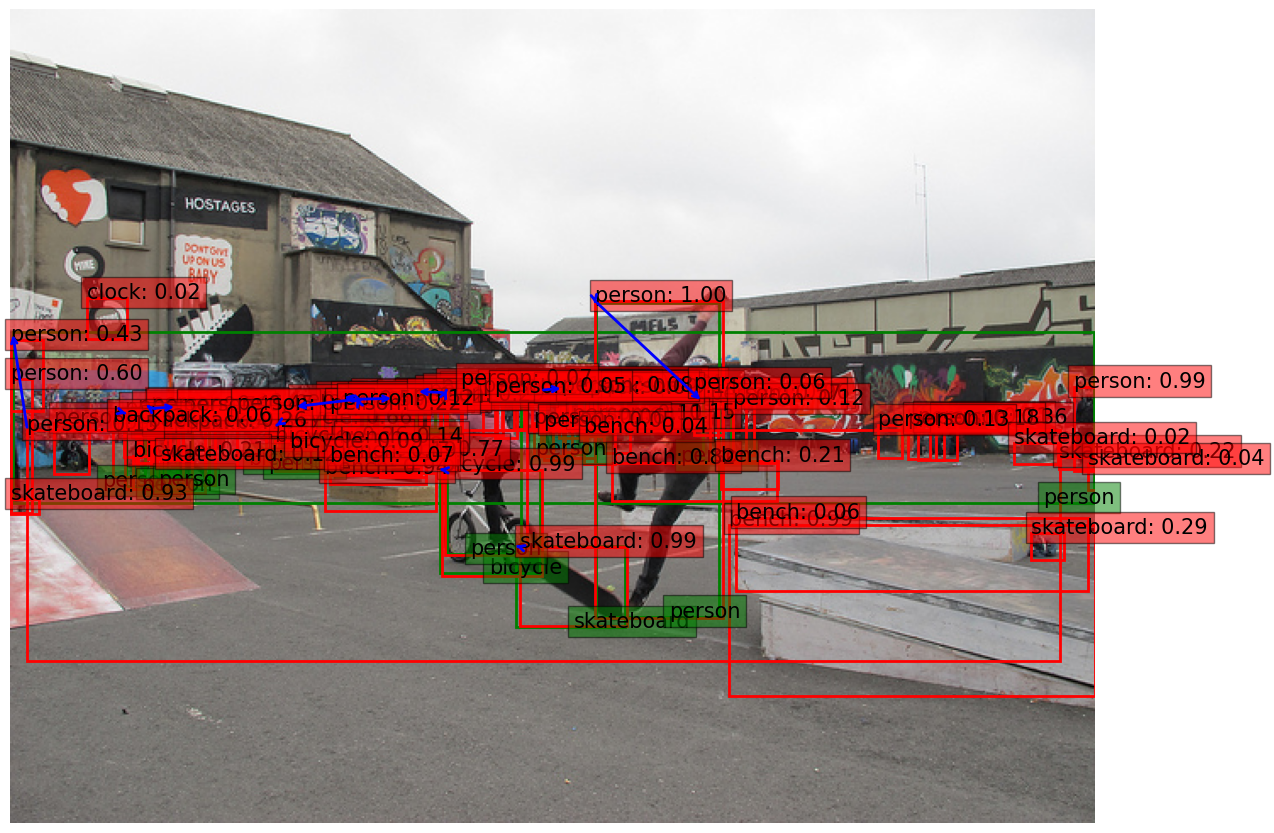

Number of ground truths: 17
Number of predictions: 80
Number of filtered prediction: 80


In [13]:
from cods.od.visualization import plot_preds

# Plot ground truths and predictions for the image with index 0
idx = 3
plot_preds(idx, preds_cal, None, idx_to_label=MSCOCODataset.NAMES)
print("Number of ground truths:", len(preds_cal.true_cls[idx]))
print("Number of predictions:", len(preds_cal.confidences[idx]))
print(
    "Number of filtered prediction:",
    sum(preds_cal.confidences[idx] > preds_cal.confidence_threshold).item(),
)

In [14]:
conformal_preds = conf.conformalize(preds_val, parameters=parameters)

[2025-05-07 02:26:28:INFO:cp.py:cp:1858 - conformalize ] Conformalizing Predictions
[2025-05-07 02:26:28:INFO:cp.py:cp:1861 - conformalize ] Using provided parameters for conformalization
[2025-05-07 02:26:28:INFO:cp.py:cp:1867 - conformalize ] The parameters have been computed on another set of predictions.
[2025-05-07 02:26:28:INFO:cp.py:cp:1879 - conformalize ] Conformalizing Confidence
[2025-05-07 02:26:28:INFO:cp.py:cp:1898 - conformalize ] Conformalizing Localization
[2025-05-07 02:26:28:INFO:cp.py:cp:571 - conformalize ] Using previous λ for localization
[2025-05-07 02:26:28:INFO:cp.py:cp:586 - conformalize ] Conformalizing Localization with λ
[2025-05-07 02:26:28:INFO:cp.py:cp:1909 - conformalize ] Conformalizing Classification


In [15]:
# TODO: Rewrite it so we only compute the confidence loss and not the max of three. Main loss of condiecne shoudl be just itself but in calibration use the proxy maximum loss with the others
results_val = conf.evaluate(
    preds_val,
    parameters=parameters,
    conformalized_predictions=conformal_preds,
    include_confidence_in_global=False,
)

Confidence threshold is 2.4974346160888672e-05
Matching is : True
Matching complete
Confidence threshold: 2.4974346160888672e-05
ODParameters
global_alpha: 0.12000000000000001
alpha_confidence: 0.02
alpha_localization: 0.05
alpha_classification: 0.05
lambda_confidence_plus: 0.9999750256538391
lambda_confidence_minus: 0.9999732971191406
lambda_localization: 10.8642578125
lambda_classification: 0.9999924600124359
confidence_threshold: 2.4974346160888672e-05


/home/leo.andeol/envs/cods_13/cods/cods/od/loss.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss).float().to(self.device).expand(1)
[2025-05-07 02:26:33:INFO:cp.py:cp:2026 - evaluate ] Evaluation Results:
[2025-05-07 02:26:33:INFO:cp.py:cp:2028 - evaluate ] 	 Confidence:
[2025-05-07 02:26:33:INFO:cp.py:cp:2029 - evaluate ] 		 Risk: 0.02
[2025-05-07 02:26:33:INFO:cp.py:cp:2030 - evaluate ] 		 Mean Set Size: 40.30
[2025-05-07 02:26:33:INFO:cp.py:cp:2034 - evaluate ] 	 Localization:
[2025-05-07 02:26:33:INFO:cp.py:cp:2035 - evaluate ] 		 Risk: 0.05
[2025-05-07 02:26:33:INFO:cp.py:cp:2036 - evaluate ] 		 Mean Set Size: 1.76
[2025-05-07 02:26:33:INFO:cp.py:cp:2040 - evaluate ] 	 Classification:
[2025-05-07 02:26:33:INFO:cp.py:cp:2041 - evaluate ] 		 Risk: 0.05
[2025-05-07 02:26:33:INFO:cp.py:cp:2042 - evaluate ]

Using confidence threshold from preds


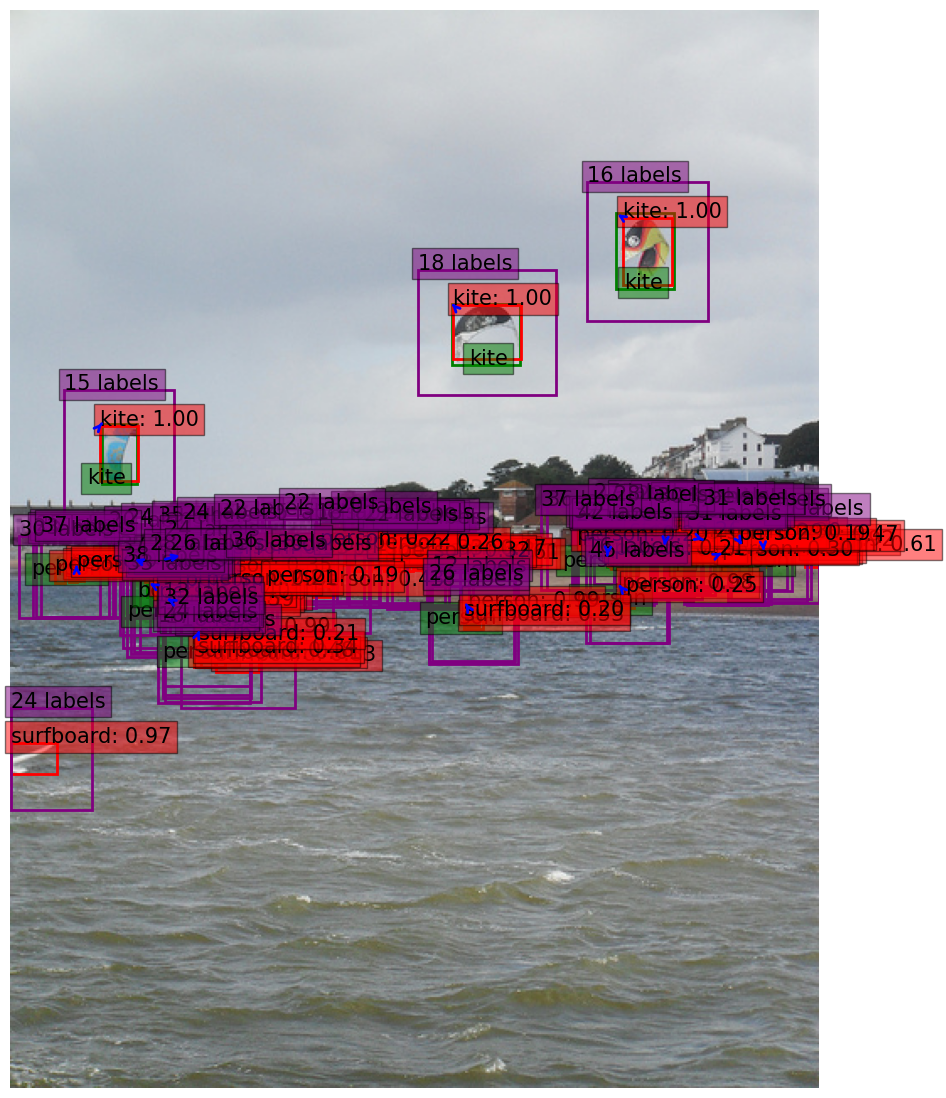

In [ ]:
idx = 12
plot_preds(idx, preds_val, conformal_preds, idx_to_label=MSCOCODataset.NAMES)


In [ ]:
pred_cls = preds_val.pred_cls[idx]
pred_conf = preds_val.confidence[idx]
true_cls = preds_val.true_cls[idx]
matching = preds_val.matching[idx]

pairs = [
    (x, preds_val.pred_cls[matching[i][0]].argmax())
    for i, x in enumerate(true_cls)
]
for x, y in pairs:
    print(f"{x=}, {y=}")

x=tensor(1), y=tensor(1)
x=tensor(1), y=tensor(1)
x=tensor(1), y=tensor(1)
x=tensor(38), y=tensor(1)
x=tensor(38), y=tensor(77)
x=tensor(9), y=tensor(48)
x=tensor(38), y=tensor(1)
x=tensor(1), y=tensor(42)
x=tensor(1), y=tensor(59)
x=tensor(1), y=tensor(1)
x=tensor(1), y=tensor(62)
x=tensor(1), y=tensor(6)
x=tensor(1), y=tensor(17)
x=tensor(1), y=tensor(1)
x=tensor(1), y=tensor(49)
x=tensor(1), y=tensor(81)
x=tensor(1), y=tensor(6)


In [ ]:
print(matching)

[[3], [5], [10], [1], [0], [20], [2], [4], [8], [17], [36], [69], [40], [19], [32], [34], [61]]


In [ ]:
from cods.od.metrics import unroll_metrics

unroll_metrics(preds_val, conformal_preds)

Defaulting to predictions' confidence threshold


TypeError: getAveragePrecision() got multiple values for argument 'verbose'